## Backtest simulation for only investing in SPY ** 

In [1]:
# %pip install pyproject-toml
%pip install pandas_ta

  Using cached pandas_ta-0.3.14b0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [378]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)
    

# Backtesting Class

In [379]:
class BacktestingSystem:
    def __init__(self, investment_cash=5):
        self.data = None
        self.investment_cash = investment_cash
    
    # Download data from yfinance
    def load_data(self, symbol, start_date, end_date):
        print(symbol)
        self.data = yf.download(symbol,start_date, end_date)
    
    # Visualize Results
    def plot_results(self, portfolio):
        plt.style.use('fivethirtyeight')

    
        fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    
        # Plot stock price
        ax[0].plot(self.data['Close'], label='Price', color='steelblue', linewidth=2)
        ax[0].set_ylabel('Price', fontsize=12)
        ax[0].legend(loc='upper left', fontsize=10)
    
        # Plot portfolio value
        ax[1].plot(portfolio['position'], label='Portfolio Value', color='forestgreen', linewidth=2)
        ax[1].set_ylabel('Portfolio Value', fontsize=12)
        ax[1].legend(loc='upper left', fontsize=10)
    
        # Set x-axis label for the last subplot
        ax[1].set_xlabel('Date', fontsize=12)
    
        # Adjust spacing between subplots
        plt.tight_layout(pad=2)
    
        # Set title and axis labels
        fig.suptitle('Backtesting Results', fontsize=16, fontweight='bold')
    
        # Customize tick parameters
        plt.tick_params(axis='both', which='both', bottom=False, left=False)
    
        # Remove spines
        for axis in ['top', 'right']:
            ax[0].spines[axis].set_visible(False)
            ax[1].spines[axis].set_visible(False)
    
        # Display the plot
        plt.show()

    def backtest_strategy(self, strategy):
        signals = strategy.generate_signals()
        positions = signals['signal']
        portfolio = pd.DataFrame(index=signals.index)
        portfolio['position'] = positions
        portfolio['Close'] = signals['Close']
        
        portfolio['Investment'] = self.investment_cash

        # portfolio['total'] = (portfolio['position'] * portfolio['Close']).cumsum()

        portfolio['total'] = (portfolio['position'] * portfolio['Investment']).cumsum()

        Total_money_invested = portfolio['total'].iloc[-1]

        portfolio_spy_avg = portfolio[portfolio['position']==1]['Close'].mean()

        portfolio_total_shares = portfolio['total'].iloc[-1]/ portfolio[portfolio['position']==1]['Close'].mean()


        # Calculate portfolio value

        print("\n")
        print('Total money invested: $', int(Total_money_invested  )  )
        print("\n")
        print('Total Portfolio value : $', int(portfolio_total_shares * portfolio['Close'].iloc[-1] ) )
        print("\n")
        print('Portfolio up %  : ', int(100 - (int(Total_money_invested)/int(portfolio_total_shares * portfolio['Close'].iloc[-1] ))*100 ))
        print("\n")
        print('The average SPY price of the portfolio is: ', portfolio_spy_avg )
        print("\n")
        print("The Stock average price if invested DAILY : $ ",portfolio['Close'].mean())
        print("\n")
        print('No. of shares: ', portfolio_total_shares  )
        print("\n")
        print('Profit till the date : $', (portfolio_total_shares * portfolio['Close'].iloc[-1]) - Total_money_invested )
        print("\n")

        return portfolio

## TODO :


In [522]:
# Moving Average Crossover Strategy

class FearandGreedIndexStrategy:
    def __init__(self, data,fear_data):
        self.data = data
        self.fear_data = fear_data

    def fear_category(self,x):
        if x <= 25:
            return "Extreme fear"
        elif (x <= 50) and (x > 25):
            return "Fear"
        elif (x <= 75) and (x > 50):
            return "Greed"
        elif (x <= 100) and (x > 75):
            return "Extreme Greed"
        
    def calculate_rsi(self, data, period=21):
        Close_prices = data['Fear_index']
        price_changes = Close_prices.diff()

        gains = price_changes.mask(price_changes < 0, 0)
        losses = -price_changes.mask(price_changes > 0, 0)

        average_gain = gains.rolling(window=period).mean()
        average_loss = losses.rolling(window=period).mean()

        rs = average_gain / average_loss
        rsi = 100 - (100 / (1 + rs))

        return rsi
    
    # STOCHASTIC OSCILLATOR CALCULATION

    def get_stoch_osc(self, high, low, close, k_lookback, d_lookback):
        lowest_low = low.rolling(k_lookback).min()
        highest_high = high.rolling(k_lookback).max()
        k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
        d_line = k_line.rolling(d_lookback).mean()
        return k_line, d_line

    
    def generate_signals(self):
        Complete_df = pd.merge(self.fear_data, self.data, on='Date', how='inner').set_index('Date')
        Complete_df['signal'] = 0
        
        Complete_df[['k', 'd']] = self.get_stoch_osc(Complete_df['High'], Complete_df['Low'], Complete_df['Close'], 21, 6)
        Complete_df['Fear_Strength_index'] = self.calculate_rsi(Complete_df, period=21)
        
        Complete_df.dropna(inplace=True)

        condition = (Complete_df[['k', 'd']] <= [20, 20]).sum(axis=1) >= 1
        condition &= Complete_df['pull_call_ratio'] > 1
        condition &= Complete_df['Fear_Strength_index'] <= 60

        Complete_df['signal'] = condition.astype(int)
        
        return Complete_df


# Addtions
- Add MA or EMA to buy
- Puts and Calls ratio : Use the same URL to scrape

SPY
[*********************100%***********************]  1 of 1 completed


Total money invested: $ 3500


Total Portfolio value : $ 4040


Portfolio up %  :  13


The average SPY price of the portfolio is:  377.85771484375


The Stock average price if invested DAILY : $  405.4806058592343


No. of shares:  9.262745902772698


Profit till the date : $ 540.1320047900595




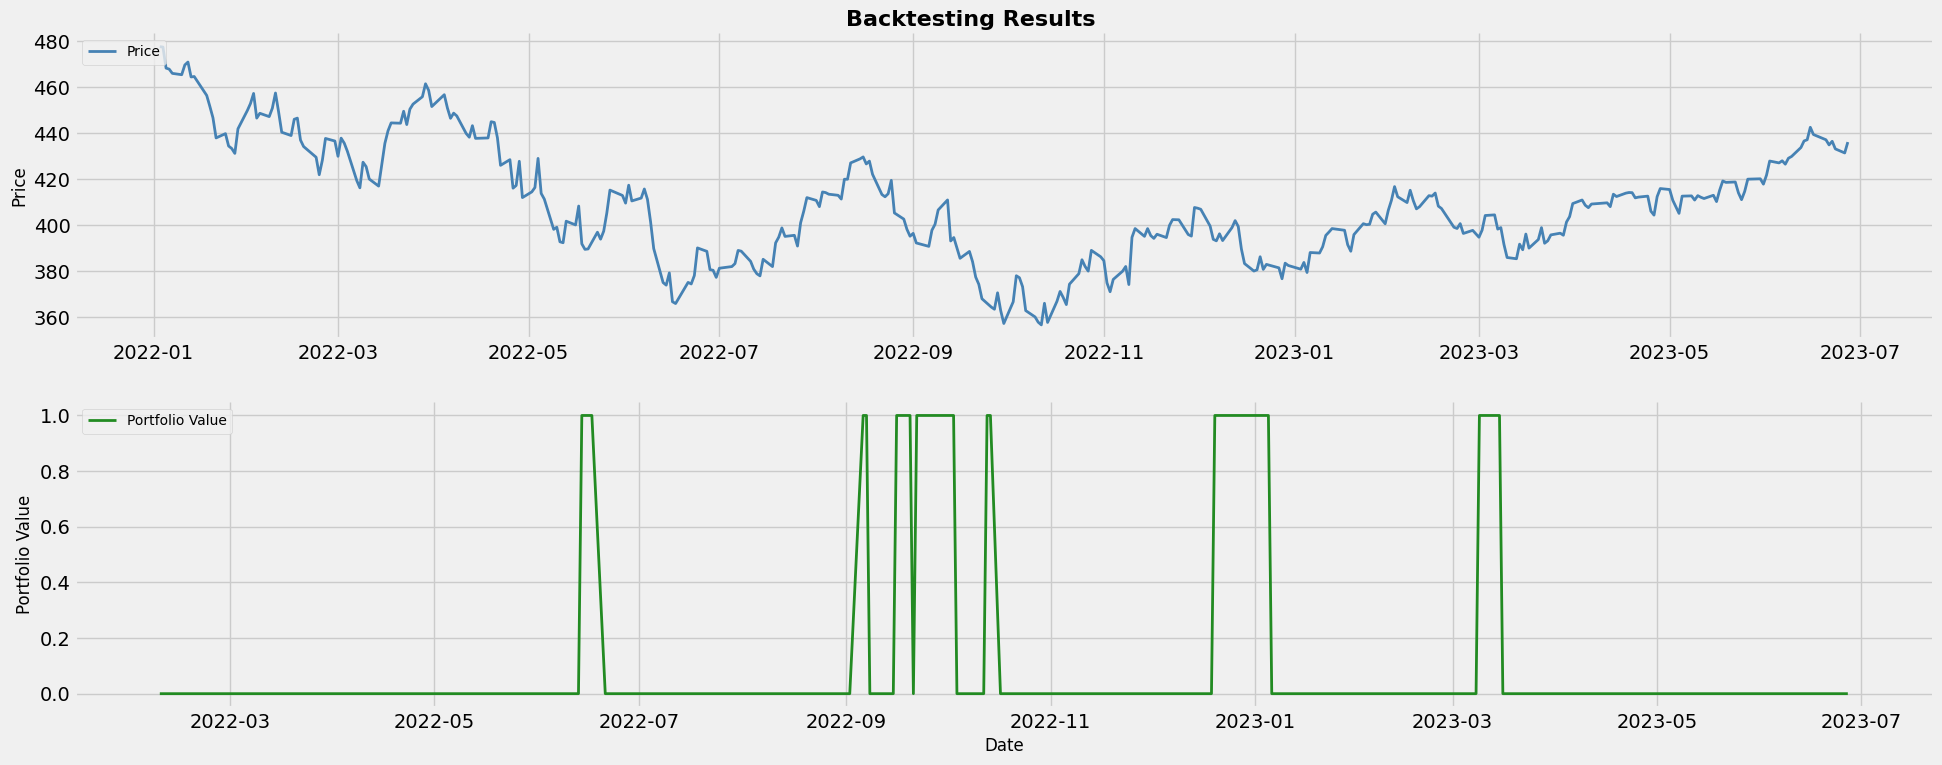

In [526]:
# Initiate Backtesting and Load Data
backtester = BacktestingSystem(investment_cash=100)
backtester.load_data('SPY', '2022-01-01' ,'2023-06-28')

# Inporting the fear and greed data
Fear_data = pd.read_csv(r'C:\Users\vamsh\OneDrive\Desktop\Trading_Bot_version_1\Data\fearindex_pull_ratio_2021.csv',index_col=0)
Fear_data.columns = ['Date','Fear_index','pull_call_ratio']
Fear_data['Date'] = pd.to_datetime(Fear_data['Date'])     

# # Usage Example for Moving Average strategy
moving_average_strategy = FearandGreedIndexStrategy(backtester.data,Fear_data)
moving_average_portfolio = backtester.backtest_strategy(moving_average_strategy)
backtester.plot_results(moving_average_portfolio)
# backtester.plot_indicator(moving_average_strategy.generate_signals())

In [496]:
test = moving_average_strategy.generate_signals()

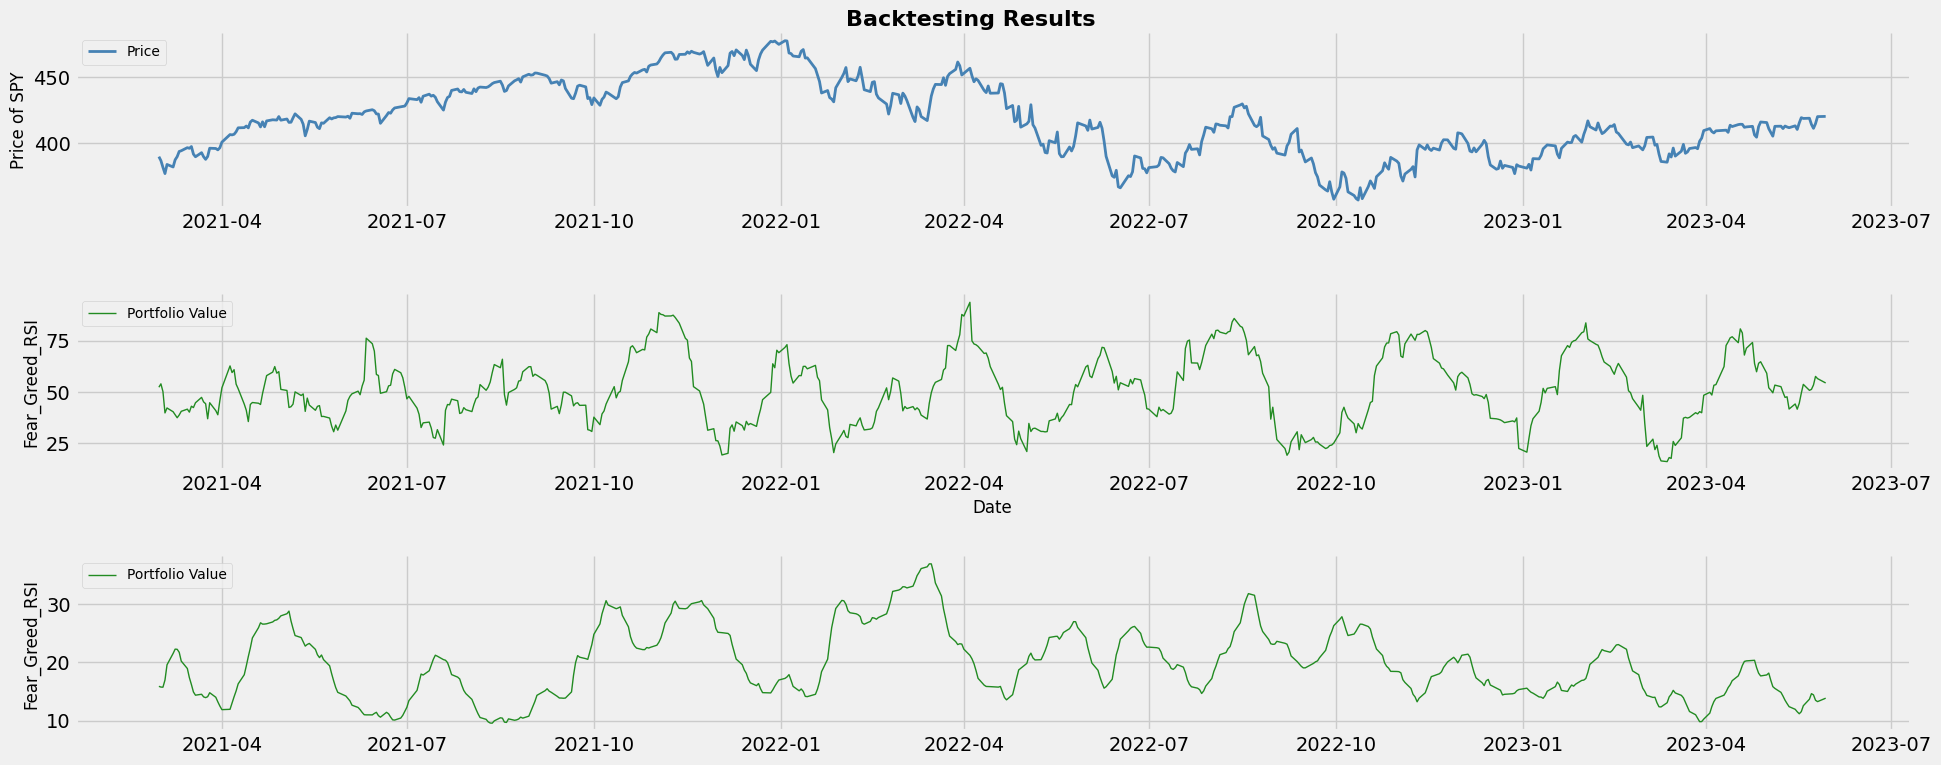

In [413]:
plt.style.use('fivethirtyeight')

    
fig, ax = plt.subplots(3, 1, figsize=(20, 8))

# Plot stock price
ax[0].plot(moving_average_strategy.generate_signals()['Close'], label='Price', color='steelblue', linewidth=2)
ax[0].set_ylabel('Price of SPY', fontsize=12)
ax[0].legend(loc='upper left', fontsize=10)

# Plot portfolio value
ax[1].plot(moving_average_strategy.generate_signals()['Fear_Strength_index'], label='Portfolio Value', color='forestgreen', linewidth=1)
ax[1].set_ylabel('Fear_Greed_RSI', fontsize=12)
ax[1].legend(loc='upper left', fontsize=10)

# Plot portfolio value
ax[2].plot(moving_average_strategy.generate_signals()['adx'], label='Portfolio Value', color='forestgreen', linewidth=1)
ax[2].set_ylabel('Fear_Greed_RSI', fontsize=12)
ax[2].legend(loc='upper left', fontsize=10)

# Set x-axis label for the last subplot
ax[1].set_xlabel('Date', fontsize=12)

# Adjust spacing between subplots
plt.tight_layout(pad=2)

# Set title and axis labels
fig.suptitle('Backtesting Results', fontsize=16, fontweight='bold')

# Customize tick parameters
plt.tick_params(axis='both', which='both', bottom=False, left=False)

# Remove spines
for axis in ['top', 'right']:
    ax[0].spines[axis].set_visible(False)
    ax[1].spines[axis].set_visible(False)
    ax[2].spines[axis].set_visible(False)

# Display the plot
plt.show()

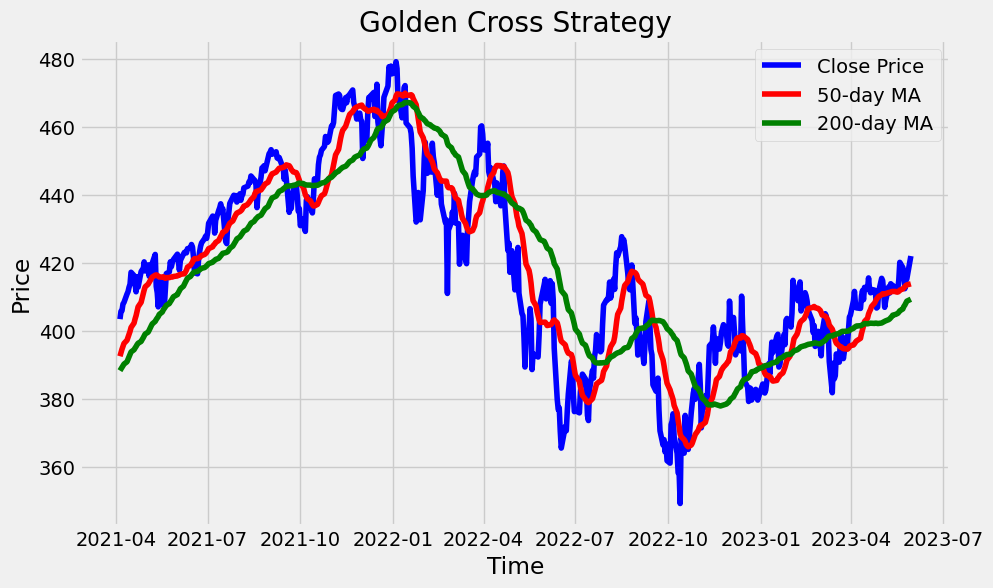

In [263]:
test

plt.figure(figsize=(10, 6))
plt.plot(test['Close'], color='blue', label='Close Price')
plt.plot(test['MA_50'], color='red', label='50-day MA')
plt.plot(test['MA_200'], color='green', label='200-day MA')
plt.legend()
plt.title('Golden Cross Strategy')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

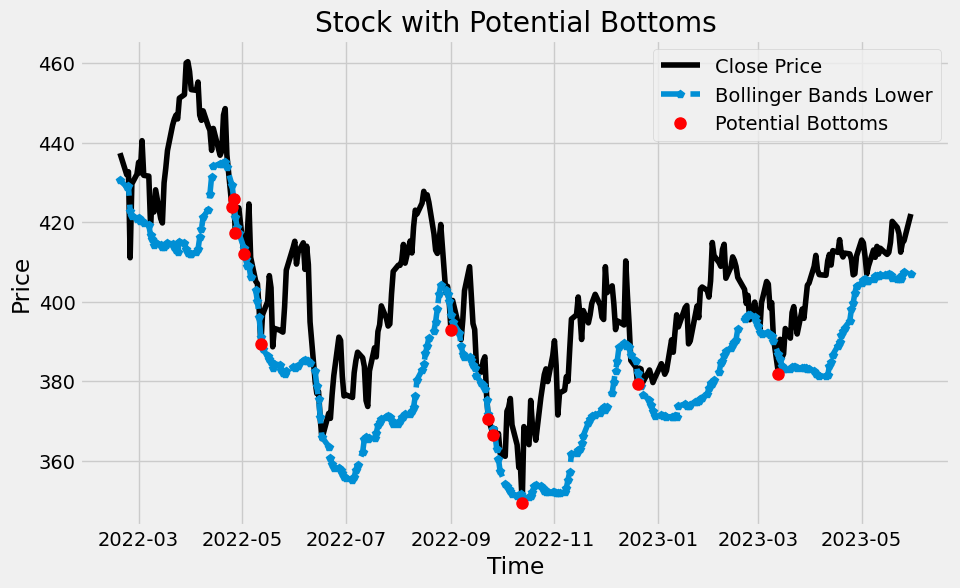

In [167]:
# Plotting the chart with potential bottoms
plt.figure(figsize=(10, 6))
plt.plot(test['Close'], color='black', label='Close Price')
plt.plot(test['BBL_21_2.0'], 'p--', label='Bollinger Bands Lower')
plt.plot(bottoms.index, bottoms['Close'], 'ro', markersize=8, label='Potential Bottoms')
plt.legend()
plt.title('Stock with Potential Bottoms')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

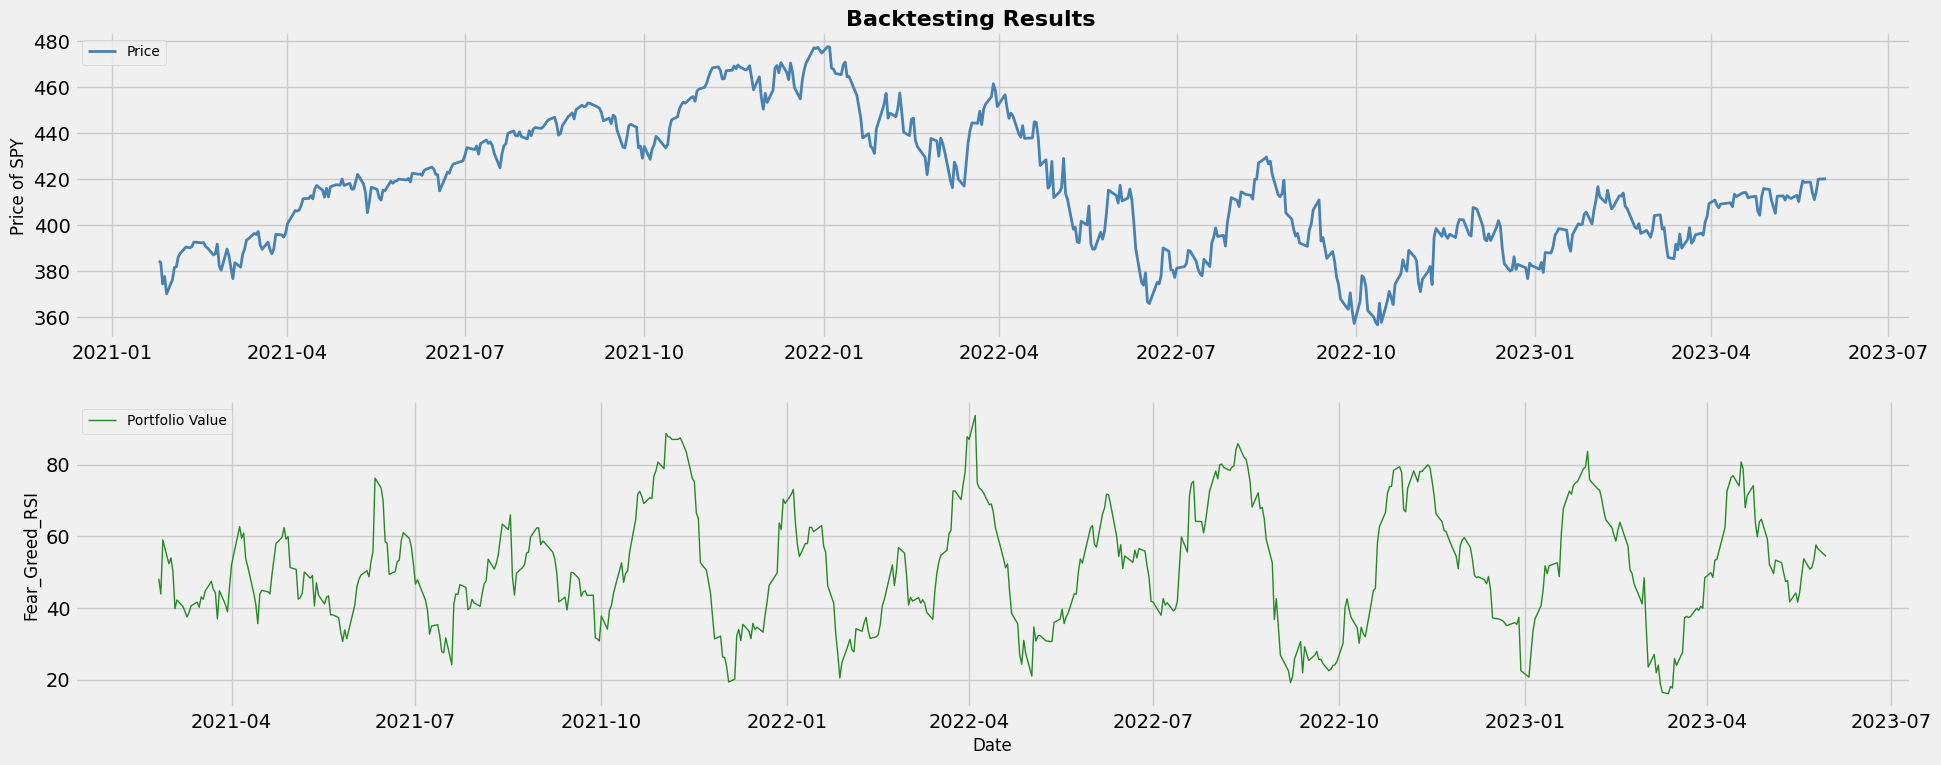

In [76]:
plt.style.use('fivethirtyeight')

    
fig, ax = plt.subplots(2, 1, figsize=(20, 8))

# Plot stock price
ax[0].plot(moving_average_strategy.generate_signals()['Close'], label='Price', color='steelblue', linewidth=2)
ax[0].set_ylabel('Price of SPY', fontsize=12)
ax[0].legend(loc='upper left', fontsize=10)

# Plot portfolio value
ax[1].plot(calculate_rsi(moving_average_strategy.generate_signals(), period=21), label='Portfolio Value', color='forestgreen', linewidth=1)
ax[1].set_ylabel('Fear_Greed_RSI', fontsize=12)
ax[1].legend(loc='upper left', fontsize=10)

# Set x-axis label for the last subplot
ax[1].set_xlabel('Date', fontsize=12)

# Adjust spacing between subplots
plt.tight_layout(pad=2)

# Set title and axis labels
fig.suptitle('Backtesting Results', fontsize=16, fontweight='bold')

# Customize tick parameters
plt.tick_params(axis='both', which='both', bottom=False, left=False)

# Remove spines
for axis in ['top', 'right']:
    ax[0].spines[axis].set_visible(False)
    ax[1].spines[axis].set_visible(False)

# Display the plot
plt.show()